In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold



# ─── Reproducibility ─────────────────────────────────────────────────────────
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# ─── 1) Load & shuffle dataset ───────────────────────────────────────────────
data = np.load('data/threebody_dataset2.npz')
X_all    = data['X']            # (N_runs, TIMESTEPS, 6)
masses   = data['masses']       # (N_runs, 3)
init_pos = data['init_pos']     # (N_runs, 3, 2)
init_vel = data['init_vel']     # (N_runs, 3, 2)

X_all, masses, init_pos, init_vel = shuffle(
    X_all, masses, init_pos, init_vel,
    random_state=SEED
)

In [131]:
# ─── 2) Conditioning function & build_inputs ─────────────────────────────────
def prepare_conditioning(idx):
    pos = init_pos[idx].copy()
    vel = init_vel[idx].copy()
    m   = masses[idx]
    M   = m.sum()
    xcm = (pos[:,0] * m).sum() / M
    ycm = (pos[:,1] * m).sum() / M
    vxcm = (vel[:,0] * m).sum() / M
    vycm = (vel[:,1] * m).sum() / M
    pos[:,0] -= xcm; pos[:,1] -= ycm
    vel[:,0] -= vxcm; vel[:,1] -= vycm
    return np.hstack([m, pos.flatten(), vel.flatten()])  # (15,)

TIMESTEPS = X_all.shape[1]
INPUT_DIM = 6 + 15
TARGET_DIM= 6

def build_inputs(idx):
    traj     = X_all[idx]                   # (TIMESTEPS, 6)
    cond_vec = prepare_conditioning(idx)    # (15,)
    cond_rep = np.repeat(cond_vec[None,:], TIMESTEPS, axis=0)  # (TIMESTEPS, 15)
    return np.hstack([traj, cond_rep])     # (TIMESTEPS, 21)


In [ ]:
# ─── 3) Train / Val / Test splits ────────────────────────────────────────────
N          = len(X_all)
TRAIN_END  = int(0.7 * N)
VAL_END    = int(0.85 * N)

train_idx = list(range(0, TRAIN_END))
val_idx   = list(range(TRAIN_END, VAL_END))
test_idx  = list(range(VAL_END, N))

WASHOUT   = 100

def stack_data(idxs):
    Xs = np.vstack([build_inputs(i)[:-1] for i in idxs])
    Ys = np.vstack([X_all[i,1:,:]       for i in idxs])
    return Xs, Ys

X_train, Y_train = stack_data(train_idx)
X_val,   Y_val   = stack_data(val_idx)
X_test,  Y_test  = stack_data(test_idx)

In [133]:
# ─── 4) Scale inputs & targets ──────────────────────────────────────────────
in_scaler  = StandardScaler().fit(X_train)
tg_scaler  = StandardScaler().fit(Y_train)

X_train_s = in_scaler.transform(X_train)
Y_train_s = tg_scaler.transform(Y_train)
X_val_s   = in_scaler.transform(X_val)
Y_val_s   = tg_scaler.transform(Y_val)
X_test_s  = in_scaler.transform(X_test)
Y_test_s  = tg_scaler.transform(Y_test)

# reshape for RNN: (n_runs, timesteps-1, features)
def reshape_for_rnn(X, feature_dim):
    seq_len = TIMESTEPS - 1
    n_seqs  = X.shape[0] // seq_len
    return X.reshape(n_seqs, seq_len, feature_dim)

X_train_s = reshape_for_rnn(X_train_s, INPUT_DIM)
Y_train_s = reshape_for_rnn(Y_train_s, TARGET_DIM)
X_val_s   = reshape_for_rnn(X_val_s,   INPUT_DIM)
Y_val_s   = reshape_for_rnn(Y_val_s,   TARGET_DIM)
X_test_s  = reshape_for_rnn(X_test_s,  INPUT_DIM)
Y_test_s  = reshape_for_rnn(Y_test_s,  TARGET_DIM)

In [141]:
# ─── 5) Hyperparameter grid & training ─────────────────────────────────────
grid = {
    'n_layers':     [2],
    'units':        [256],
    'dropout':      [0.01],
    'learning_rate':[1e-3],
    'batch_size':   [32],
}

best_mse    = np.inf
best_params = None
best_model  = None

for n_layers in grid['n_layers']:
    for units in grid['units']:
        for dropout in grid['dropout']:
            for lr in grid['learning_rate']:
                for bs in grid['batch_size']:
                    print(f"→ GRU(n_layers={n_layers}, units={units}, "
                          f"dropout={dropout}, lr={lr}, batch_size={bs})")
                    
                    # build stacked GRU
                    model = Sequential()
                    for layer in range(n_layers):
                        if layer == 0:
                            model.add(GRU(units,
                                        return_sequences=True,
                                        input_shape=(TIMESTEPS-1, INPUT_DIM)))
                        else:
                            model.add(GRU(units, return_sequences=True))
                        model.add(Dropout(dropout))
                    model.add(Dense(TARGET_DIM))
                                        
                    model.compile(
                        optimizer=Adam(learning_rate=lr),
                        loss='mse'
                    )
                    
                    es = EarlyStopping(
                        monitor='val_loss',
                        patience=10,
                        restore_best_weights=True
                    )
                    
                    model.fit(
                        X_train_s, Y_train_s,
                        validation_data=(X_val_s, Y_val_s),
                        epochs=50,
                        batch_size=bs,
                        callbacks=[es],
                        verbose=1
                    )
                    
                    # aggregate validation metrics
                    preds_val = model.predict(X_val_s)                # (n_val, seq, TARGET_DIM)
                    preds_val = preds_val[:, WASHOUT:, :].reshape(-1, TARGET_DIM)
                    true_val  = Y_val_s[:, WASHOUT:, :].reshape(-1, TARGET_DIM)
                    preds_val = tg_scaler.inverse_transform(preds_val)
                    true_val  = tg_scaler.inverse_transform(true_val)
                    
                    mse = mean_squared_error(true_val, preds_val)
                    print(f"   Val MSE: {mse:.6f}")
                    
                    if mse < best_mse:
                        best_mse    = mse
                        best_params = {
                            'n_layers':n_layers,
                            'units':   units,
                            'dropout': dropout,
                            'learning_rate': lr,
                            'batch_size': bs
                        }
                        best_model  = model

print("\nBest params:", best_params)
print(f"Best Val MSE: {best_mse:.6f}")

→ GRU(n_layers=2, units=256, dropout=0.01, lr=0.001, batch_size=32)
Epoch 1/50
7/7 [==============================] - 33s 5s/step - loss: 0.6441 - val_loss: 0.9891
Epoch 2/50
7/7 [==============================] - 31s 5s/step - loss: 0.2132 - val_loss: 0.7963
Epoch 3/50
7/7 [==============================] - 31s 4s/step - loss: 0.1464 - val_loss: 0.7698
Epoch 4/50
7/7 [==============================] - 31s 4s/step - loss: 0.1079 - val_loss: 0.6802
Epoch 5/50
7/7 [==============================] - 33s 5s/step - loss: 0.0851 - val_loss: 0.6757
Epoch 6/50
7/7 [==============================] - 32s 5s/step - loss: 0.0725 - val_loss: 0.6843
Epoch 7/50
7/7 [==============================] - 31s 5s/step - loss: 0.0606 - val_loss: 0.6745
Epoch 8/50
7/7 [==============================] - 31s 4s/step - loss: 0.0546 - val_loss: 0.6422
Epoch 9/50
7/7 [==============================] - 31s 5s/step - loss: 0.0465 - val_loss: 0.6238
Epoch 10/50
7/7 [==============================] - 32s 5s/step - los

In [143]:
# ─── 6) Validation on VAL set ────────────────────────────────────────────────
val_preds_s = best_model.predict(X_val_s)  
# flatten and discard washout
val_preds_s = val_preds_s.reshape(-1, TARGET_DIM)[WASHOUT:]
true_val_s  = Y_val_s.reshape(-1, TARGET_DIM)[WASHOUT:]

# invert scaling
val_preds = tg_scaler.inverse_transform(val_preds_s)
true_val  = tg_scaler.inverse_transform(true_val_s)

mse_val = mean_squared_error(true_val, val_preds)
mae_val = mean_absolute_error(true_val, val_preds)
print(f"Validation MSE: {mse_val:.6f}, MAE: {mae_val:.6f}")

# ─── 7) Final Test Evaluation ───────────────────────────────────────────────
test_preds_s = best_model.predict(X_test_s)
# flatten and discard washout
test_preds_s = test_preds_s.reshape(-1, TARGET_DIM)[WASHOUT:]
true_test_s  = Y_test_s.reshape(-1, TARGET_DIM)[WASHOUT:]

# invert scaling
test_preds = tg_scaler.inverse_transform(test_preds_s)
true_test  = tg_scaler.inverse_transform(true_test_s)

mse_test = mean_squared_error(true_test, test_preds)
mae_test = mean_absolute_error(true_test, test_preds)
print(f"Test      MSE: {mse_test:.6f}, MAE: {mae_test:.6f}")


2/2 [==============================] - 2s 1s/step
Validation MSE: 2665535.250000, MAE: 156.022263
2/2 [==============================] - 2s 1s/step
Test      MSE: 26360.431641, MAE: 38.124783


1/1 [==============================] - 0s 255ms/step


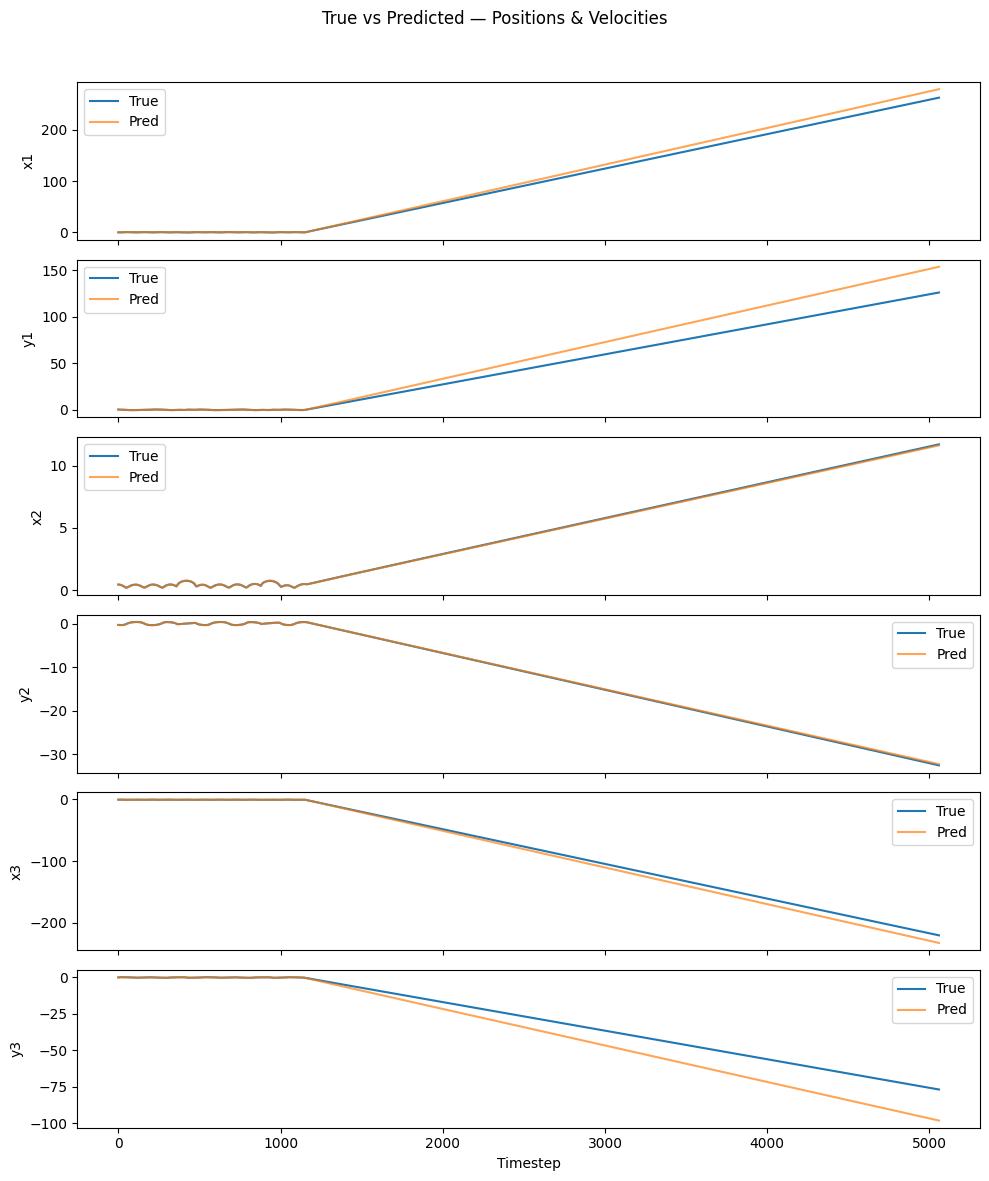

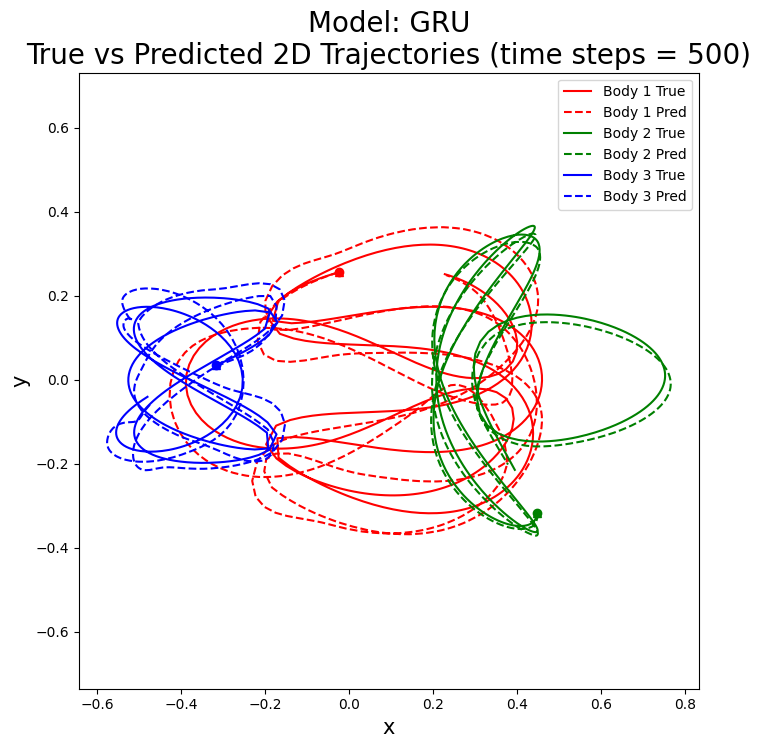

In [153]:
# ─── 7) Plot validation results (single run) ────────────────────────────────
val_run = random.choice(val_idx)
val_in  = build_inputs(val_run)[:-1]
val_s   = in_scaler.transform(val_in).reshape(1, TIMESTEPS-1, INPUT_DIM)
pred_s  = best_model.predict(val_s)[0]                       # (seq, TARGET_DIM)
pred_f  = tg_scaler.inverse_transform(pred_s)                # (seq, 6)
true_f  = X_all[val_run,1:,:]                                # (seq, 6)
preds   = pred_f[WASHOUT:];  trues = true_f[WASHOUT:]
shift   = trues[0] - preds[0]; preds += shift

# (a) Positions & velocities
fig, axs = plt.subplots(6,1,figsize=(10,12), sharex=True)
coords = ['x1','y1','x2','y2','x3','y3']
for i, ax in enumerate(axs):
    ax.plot(trues[:,i], label='True')
    ax.plot(preds[:,i], label='Pred', alpha=0.7)
    ax.set_ylabel(coords[i]); ax.legend()
axs[-1].set_xlabel('Timestep')
plt.suptitle('True vs Predicted — Positions & Velocities')
plt.tight_layout(rect=[0,0,1,0.96]); plt.show()

# (b) 2D trajectories
n_plot = 500
tt = trues[:n_plot]; pp = preds[:n_plot]
fig, ax = plt.subplots(figsize=(8,8))
colors = ['r','g','b']
for i, c in enumerate(colors):
    ax.plot(tt[:,2*i], tt[:,2*i+1], '-',  label=f'Body {i+1} True',  color=c)
    ax.plot(pp[:,2*i], pp[:,2*i+1], '--', label=f'Body {i+1} Pred',  color=c)
    ax.plot(tt[0,2*i], tt[0,2*i+1], 'o',  color=c)
    ax.plot(pp[0,2*i], pp[0,2*i+1], '^',  color=c)
ax.set_title(f'Model: GRU\nTrue vs Predicted 2D Trajectories (time steps = {n_plot})', fontsize=20)
ax.set_xlabel('x', fontsize=15); ax.set_ylabel('y', fontsize=15); ax.axis('equal'); ax.legend()
plt.show()

In [145]:
import pandas as pd

# ─── Compute per-timestep MAE & cumulative sum ───────────────────────────────
# 'preds' and 'trues' are both (T, 6) after washout & alignment
abs_errors     = np.abs(preds - trues)          # (T,6)
mae_per_step   = abs_errors.mean(axis=1)        # (T,)
cumulative_mae = np.cumsum(mae_per_step)        # (T,)

# ─── Build DataFrame & export ────────────────────────────────────────────────
df_error = pd.DataFrame({
    'timestep':       np.arange(len(mae_per_step)),
    'mae':            mae_per_step,
    'cumulative_mae': cumulative_mae
})

csv_path = 'cumulative_prediction_error_GRU.csv'
df_error.to_csv(csv_path, index=False)
print(f"Cumulative MAE data saved to {csv_path}")


Cumulative MAE data saved to cumulative_prediction_error_GRU.csv
